# Pilot Study: Performance comparison between MV SuSiE and FUSION
Comparison on the crossvalidation p-value accuracy of gene expression imputed by MV SuSiE and FUSION. 

In [1]:
library(dplyr)
library(tibble)
library(readr)
library(ggplot2)
library(purrr)
library(tidyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang



## Data Processing 
### TWAS-FUSION Data

In [2]:
dir = "~/Project/Alz/"
Proj = c("Alz_AC_SNP","Alz_DLPFC_SNP","Alz_PCC_SNP")
tmp = tibble(
  Proj_Name = Proj
)
fusion_data = tmp%>%mutate(
  result_data = map(Proj_Name,~read_delim(paste(dir,.x,"/result/all_result.txt",sep = ""),delim = "\t")%>%filter(FILE!="FILE")),
  result_data_TWAS = map(result_data,~.x%>%filter(!is.na(BEST.GWAS.ID))%>%select(-FILE)%>%mutate(
      MODELCV.R2 = as.numeric(MODELCV.R2),
      MODELCV.PV = p.adjust(as.numeric(MODELCV.PV), method = "fdr") ,TWAS.P.Adj = p.adjust(TWAS.P, method = "fdr"))%>%filter()
                        ),
        twas_gene = map(result_data_TWAS,~.x$ID),
        psed_gene = map(result_data_TWAS,~.x%>%filter(TWAS.P.Adj<0.05)),
        r2 = map(result_data_TWAS,~.x%>%pull(MODELCV.R2)%>%as.numeric%>%na.omit()%>%mean()),
        pval = map(result_data_TWAS,~.x%>%pull(MODELCV.PV)%>%as.numeric%>%na.omit()%>%mean())
)


Parsed with column specification:
cols(
  .default = col_character()
)

See spec(...) for full column specifications.

Parsed with column specification:
cols(
  .default = col_character()
)

See spec(...) for full column specifications.

Parsed with column specification:
cols(
  .default = col_character()
)

See spec(...) for full column specifications.



### Weight estimation for mv susie

In [3]:
total = attach("~/Project/Alz/multi_susie_pilot/mv_cv.RData")$output 
susie_data = total%>%select(-path)%>%mutate( 
  n_of_cs = map_dbl(model,~.x$sets$cs_index%>%length()),
  rmse_ac = map_dbl(model,~.x$rmse[1]),
  rmse_PCC = map_dbl(model,~.x$rmse[2]),
  rmse_DLPFC = map_dbl(model,~.x$rmse[3]),
  r2_ac = map_dbl(model,~.x$r2[1]%>%round(3)),
  r2_PCC = map_dbl(model,~.x$r2[2]%>%round(3)),
  r2_DLPFC = map_dbl(model,~.x$r2[3]%>%round(3)),
 pval_ac = map_dbl(model,~.x$pval[1]),
 pval_PCC = map_dbl(model,~.x$pval[2]),
 pval_DLPFC = map_dbl(model,~.x$pval[3])
)

### Merging of data 

In [4]:
merged_data = fusion_data%>%select(Proj_Name,twas_gene,result_data_TWAS,r2,pval)%>%mutate(
    idx = c(1,3,2),
    susie_r2 = map2(twas_gene,idx, ~ ((susie_data%>%filter(ID %in% .x)%>%select(ID,n_of_cs,pval_ac,pval_PCC,pval_DLPFC,r2_ac,r2_PCC,r2_DLPFC))[,c(1,2+3+.y)])),
    susie_pval = map2(twas_gene,idx, ~ ((susie_data%>%filter(ID %in% .x)%>%select(ID,n_of_cs,pval_ac,pval_PCC,pval_DLPFC,r2_ac,r2_PCC,r2_DLPFC))[,c(1,2+.y)])),
    sum_data = map2(result_data_TWAS,susie_r2, ~ inner_join(.x,.y )%>%
                    mutate(r2_more = .[,ncol(.)] >= MODELCV.R2%>%as.numeric() )),
    sum_data = map2(sum_data,susie_pval, ~ inner_join(.x,.y )%>%
                    mutate(pv_less = .[,ncol(.)] <= MODELCV.PV%>%as.numeric() )),
    sum_data = map(sum_data,~.x%>%
                   mutate(both_win = (r2_more & pv_less) )),
    pcnt_pv_win = map_dbl(sum_data, ~.x%>%pull(pv_less)%>%na.omit%>%mean()  ),
    pcnt_r2_win = map_dbl(sum_data, ~.x%>%pull(r2_more)%>%na.omit%>%mean()  ),
    pcnt_both_win = map_dbl(sum_data, ~.x%>%filter(both_win )%>%nrow()/nrow(.x) )
    )%>%select(-twas_gene,-idx)

Joining, by = "ID"

Joining, by = "ID"

Joining, by = "ID"

Joining, by = "ID"

Joining, by = "ID"

Joining, by = "ID"



In [5]:
merged_data%>%saveRDS("~/merged_dat.RDS")

## Data Visualization 
### Distribution of MvSuSIE CV P value 
#### PCC

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



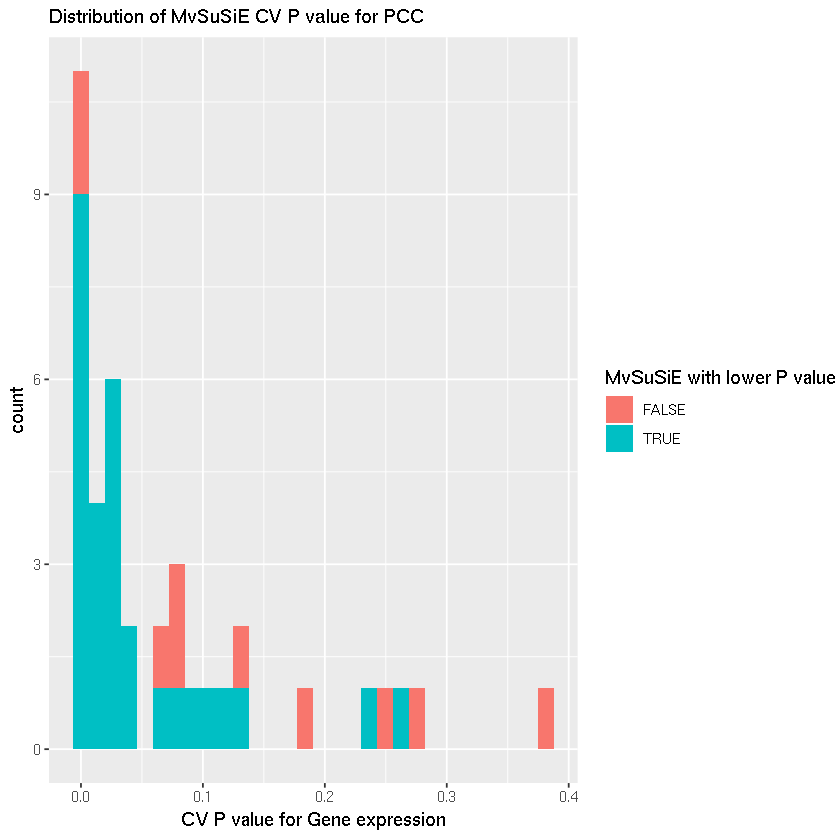

In [28]:
merged_data$sum_data[[3]]%>%filter()%>%ggplot(aes(x = pval_PCC,fill = pv_less ))+geom_histogram()+
ggtitle("Distribution of MvSuSiE CV P value for PCC")+xlab("CV P value for Gene expression")+labs(fill = "MvSuSiE with lower P value")

#### DLPFC

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



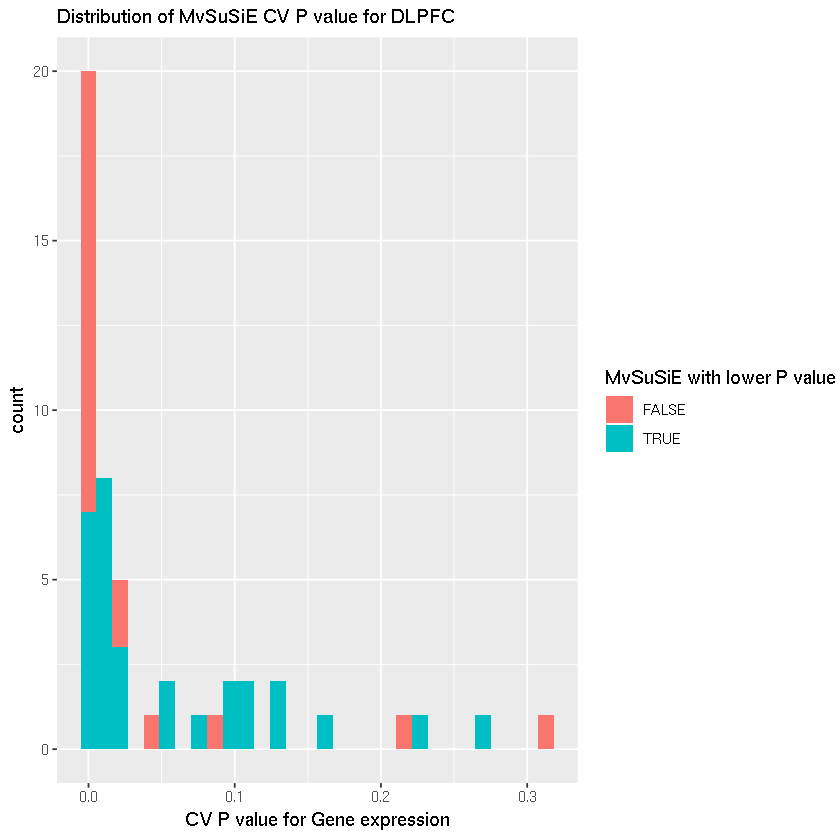

In [29]:
merged_data$sum_data[[2]]%>%filter()%>%ggplot(aes(x = pval_DLPFC,fill = pv_less ))+geom_histogram()+
ggtitle("Distribution of MvSuSiE CV P value for DLPFC")+xlab("CV P value for Gene expression")+labs(fill = "MvSuSiE with lower P value")

#### AC

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



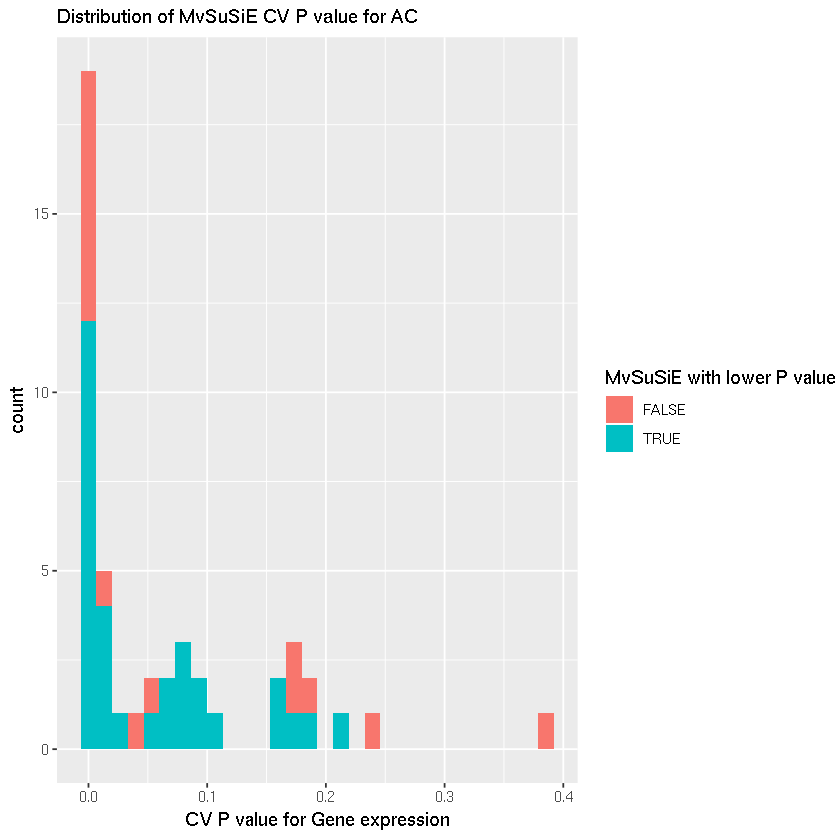

In [31]:
merged_data$sum_data[[1]]%>%filter()%>%ggplot(aes(x = pval_ac,fill = pv_less ))+geom_histogram()+
ggtitle("Distribution of MvSuSiE CV P value for AC")+xlab("CV P value for Gene expression")+labs(fill = "MvSuSiE with lower P value")

## Summary Statistics Comparison 

In [71]:
dat = data.frame()
for(i in 1:3){
    colnames(merged_data$sum_data[[i]])[23] = "susie_cv_pv"
             }

merged_data%>%mutate(tissue = c("AC","DLPFC","PCC"))%>%
                            select(tissue, sum_data)%>%
                                    unnest(sum_data)%>%
                                    group_by(tissue)%>%
                                    summarise(mean_susie_pv = mean(susie_cv_pv)%>%round(4),
                                              median_susie_pv = median(susie_cv_pv)%>%round(4),
                                              var_susie_pv = var(susie_cv_pv)%>%round(4),
                                              mean_fusion_pv = mean(MODELCV.PV)%>%round(4),
                                              median_fusion_pv = median(MODELCV.PV)%>%round(4),
                                              var_fusion_pv = var(MODELCV.PV)%>%round(4)
                                             )%>%knitr::kable()



|tissue | mean_susie_pv| median_susie_pv| var_susie_pv| mean_fusion_pv| median_fusion_pv| var_fusion_pv|
|:------|-------------:|---------------:|------------:|--------------:|----------------:|-------------:|
|AC     |        0.0648|          0.0112|       0.0076|         0.0709|           0.0277|        0.0070|
|DLPFC  |        0.0486|          0.0108|       0.0058|         0.0566|           0.0180|        0.0069|
|PCC    |        0.0724|          0.0272|       0.0090|         0.0717|           0.0446|        0.0061|